In [1]:
import os
import json
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sentencepiece as spm
from tqdm.notebook import tqdm
from wordcloud import WordCloud

random_seed = 1234
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

---

**데이터 준비**

In [2]:
## 데이터 준비

data_dir = os.getenv("HOME") + "/aiffel/bert_qna/data"
model_dir = os.getenv("HOME") + "/aiffel/bert_qna/models"

train_file = data_dir + "/KorQuAD_v1.0_train.json"
dev_file = data_dir + "/KorQuAD_v1.0_dev.json"

In [3]:
## 데이터 출력

def print_json(data, indent = "-"):
    for key, value in data.items():
        if type(value) == list: 
            print(f"{indent} {key} : list[{len(value)}]")
            print_json(value[0], indent + "-")
        else: 
            print(f"{indent} {key} : {value}")

In [4]:
## train 미리보기

with open(train_file) as f:
    train = json.load(f)
    print_json(train)

- version : KorQuAD_v1.0_train
- data : list[1420]
-- paragraphs : list[3]
--- qas : list[8]
---- answers : list[1]
----- text : 교향곡
----- answer_start : 54
---- id : 6566495-0-0
---- question : 바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?
--- context : 1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.
-- title : 파우스트_서곡


In [5]:
## dev 미리보기

with open(dev_file) as f:
    dev = json.load(f)
    print_json(dev)

- version : KorQuAD_v1.0_dev
- data : list[140]
-- paragraphs : list[2]
--- qas : list[7]
---- answers : list[1]
----- text : 1989년 2월 15일
----- answer_start : 0
---- id : 6548850-0-0
---- question : 임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
--- context : 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
-- title : 임종석


In [6]:
## vocab 로드

vocab = spm.SentencePieceProcessor()
vocab.load(model_dir + "/ko_32000.model")

True

In [7]:
## 데이터 전처리

def tokenize_space(string):
    '''
    문자열(arg)을 공백을 기준으로 분리하는 함수
    
    Returns:
        words(list): 분리된 요소(단어)
        nspace(list): 글자(char) 단위 위치 정보(이전 공백 개수)
    '''
    words = []
    nspace = []
    
    prev_space = True
    for char in string:
        if  char == " " or char == "\t" or char == "\r" or char == "\n" or ord(char) == 0x202F:
            prev_space = True
        else:
            if prev_space:
                words.append(char)
            else:
                words[-1] += char
            prev_space = False

        nspace.append(len(words) - 1)

    return words, nspace


def tokenize_subword(vocab, words):
    '''
    subword를 분리하는 함수
    
    Returns:
        subwords(list): 분리된 요소(단어)
        nsubwords(list): subwords의 위치 정보
    '''
    subwords = []
    nsubwords = []
    
    for word in words:
        nsubwords.append(len(subwords))
        subword = vocab.encode_as_pieces(word)
        for s in subword:
            subwords.append(s)
    
    return subwords, nsubwords

In [8]:
## 예시

string = '1839년 파우스트를 읽었다.'
words, nspace = tokenize_space(string)
subwords, nsubwords = tokenize_subword(vocab, words)

print('tokenize_space >', words, nspace)
print('tokenize_subword >', subwords, nsubwords)

tokenize_space > ['1839년', '파우스트를', '읽었다.'] [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2]
tokenize_subword > ['▁1839', '년', '▁', '파우스트', '를', '▁읽', '었다', '.'] [0, 2, 5]


In [9]:
## 정답 탐색

def answer_start_end(vocab, subwords, start, end, answer):
    '''
    정답의 위치 정보를 반환하는 함수
    
    Args:
        subwords(list): context subwords
        start: context에서 정답의 시작 위치
        end: context에서 정답의 끝 위치
        answer(str): 정답 
    '''
    answer = " ".join(vocab.encode_as_pieces(answer))
    for s in range(start, end + 1):
        for e in range(end, s - 1, -1):
            text = " ".join(subwords[s : e + 1])
            if text == answer:
                return (s, e)
    
    return (start, end)

In [10]:
## 데이터셋

def dumps_data(vocab, data, file):
    '''
    데이터를 정제하고 파일로 저장하는 함수
    
    Args:
        data: 로드한 json 데이터
        file: 파일을 저장할 경로
    '''
    with open(file, "w") as f:
        for d in tqdm(data["data"]):
            title = d["title"]
            for paragraph in d["paragraphs"]:
                # context
                context = paragraph["context"]
                context_words, context_nspace = tokenize_space(context) # 공백 처리
                
                for qa in paragraph["qas"]:
                    # question
                    qa_id = qa["id"]
                    question = qa["question"]
                    
                    # answer
                    assert len(qa["answers"]) == 1
                    
                    answer = qa["answers"][0]["text"]
                    answer_start = qa["answers"][0]["answer_start"]
                    answer_end = answer_start + len(answer) - 1
                    
                    assert answer == context[answer_start:answer_end + 1]
                    
                    answer_start = context_nspace[answer_start]
                    answer_end = context_nspace[answer_end]
                    
                    answer = " ".join(answer.strip().split())
                    answer_in_context = " ".join(context_words[answer_start:answer_end + 1])
                    
                    assert answer in answer_in_context
                    
                    context_subwords, context_nsubwords = tokenize_subword(vocab, context_words) # subword 처리
                    
                    answer_start = context_nsubwords[answer_start]
                    if answer_end < len(context_nsubwords) - 1:
                        answer_end = context_nsubwords[answer_end + 1] - 1
                    else:
                        answer_end = len(context_subwords) - 1
                    
                    answer_start, answer_end = answer_start_end(vocab, context_subwords, answer_start, answer_end, answer)
                    
                    # write
                    data = {"id" : qa_id, "title" : title, "question" : vocab.encode_as_pieces(question), 
                            "context" : context_subwords, "answer" : answer, "start" : answer_start, "end" : answer_end}
                    f.write(json.dumps(data, ensure_ascii = False))
                    f.write("\n")

In [11]:
dumps_data(vocab, train, f"{data_dir}/korquad_train.json")
dumps_data(vocab, dev, f"{data_dir}/korquad_dev.json")

  0%|          | 0/1420 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

---

**데이터 탐색**

In [12]:
## 데이터 저장

questions = []
contexts = []
answers_start = []

with open(f"{data_dir}/korquad_train.json") as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        questions.append(data["question"])
        contexts.append(data["context"])
        answers_start.append(data["start"])

In [13]:
## question 길이 저장

train_question_length = [len(question) for question in questions]

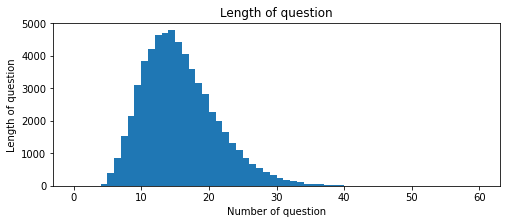

In [14]:
## question 길이 시각화

plt.figure(figsize = (8, 3))
plt.hist(train_question_length, bins = 60, range = [0, 60])
plt.title("Length of question")
plt.xlabel("Number of question")
plt.ylabel("Length of question")
plt.show()

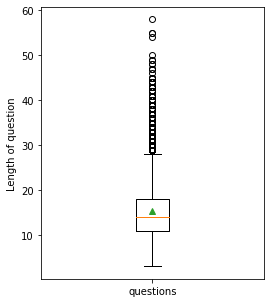

In [15]:
## question 길이 시각화

plt.figure(figsize = (4, 5))
plt.boxplot(train_question_length, labels = ["questions"], showmeans=True)
plt.ylabel("Length of question")
plt.show()

In [16]:
## question 길이 수치

pd.DataFrame(train_question_length).describe().T.style.hide_index()

count,mean,std,min,25%,50%,75%,max
60407.000000,15.245783,5.499588,3.000000,11.000000,14.000000,18.000000,58.000000


* 훈련 데이터 절반의 question 길이가 10~18이며, 대부분 40 이내입니다. 

In [17]:
## context 길이 저장

train_context_length = [len(context) for context in contexts]

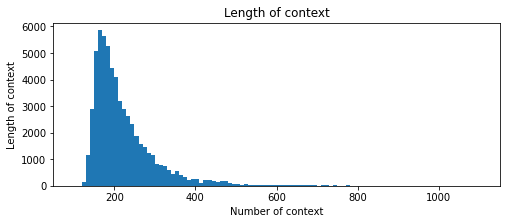

In [18]:
## context 길이 시각화

plt.figure(figsize = (8, 3))
plt.hist(train_context_length, bins = 100, range = [100, 1100])
plt.title("Length of context")
plt.xlabel("Number of context")
plt.ylabel("Length of context")
plt.show()

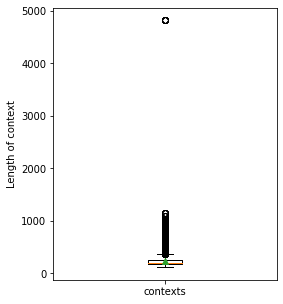

In [19]:
## context 길이 시각화

plt.figure(figsize = (4, 5))
plt.boxplot(train_context_length, labels = ["contexts"], showmeans=True)
plt.ylabel("Length of context")
plt.show()

In [20]:
## context 길이 수치

pd.DataFrame(train_context_length).describe().T.style.hide_index()

count,mean,std,min,25%,50%,75%,max
60407.000000,222.838943,97.676542,108.000000,169.000000,199.000000,248.000000,4816.000000


* 훈련 데이터 절반의 question 길이가 170~250이며, 대부분 800 이내이지만 간혹 아주 긴 데이터가 있어 분산이 매우 큽니다. 

In [21]:
## 데이터 모아보기

documents = []

for data in tqdm(train["data"]):
    # document = title + context + question
    
    title = data["title"]
    documents.append(title) # document += title
    for paragraph in data["paragraphs"]:
        context = paragraph["context"]
        documents.append(context) # document += context
        for qa in paragraph["qas"]:
            assert len(qa["answers"]) == 1
            question = qa["question"]
            documents.append(question) # document += question

  0%|          | 0/1420 [00:00<?, ?it/s]

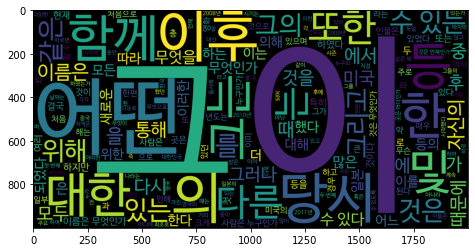

In [22]:
## 워드클라우드

font = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
wordcloud = WordCloud(width = 2000, height = 1000, font_path = font).generate(" ".join(documents))
plt.figure(figsize = (8, 4))
plt.imshow(wordcloud)

---

**데이터 로드**

In [12]:
train = os.path.join(data_dir, "korquad_train.json")
dev = os.path.join(data_dir, "korquad_dev.json")

In [13]:
## 매개변수(param) 설정

class Config(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__


max_len = Config({"max_sequence_length" : 384, "max_query_length" : 64})

In [14]:
## 데이터 로드

def load_data(max_len, file):
    '''
    파일을 로딩하고 데이터를 적절히 구축하는 함수
    
    Returns:
        x:
            x(np.array): question과 context 합의 ID
            segments(np.array): question의 길이만큼 0을, context의 길이만큼 1을 갖는 리스트
        y:
            y_start(np.array): question과 context의 합에서 정답의 시작 위치
            y_end(np.array): question과 context의 합에서 정답의 끝 위치
    '''
    x, segments, y_start, y_end = [], [], [], []
    
    nexcept = 0
    with open(file, "r") as f:
        for i, line in enumerate(tqdm(f, desc = "Loading")):
            data = json.loads(line) # loads file
            question = data["question"][:max_len.max_query_length] # question
            context = data["context"] # context
            start = data.get("start") # answer start
            end = data.get("end") # answer end
            answer = " ".join(context[start:end + 1]) # answer
            
            
            # 최대 길이 제한
            context_length = max_len.max_sequence_length - len(question) - 3
            if context_length <= end:
                nexcept += 1
                continue
            
            context = context[:context_length]
            
            assert len(question) + len(context) <= max_len.max_sequence_length - 3
            
            tokens = ['[CLS]'] + question + ['[SEP]'] + context + ['[SEP]'] # question과 context의 합
            
            # x
            ids = [vocab.piece_to_id(token) for token in tokens]
            ids += [0] * (max_len.max_sequence_length - len(ids))
            x.append(ids)
            
            # segments
            segs = [0] * (len(question) + 2) + [1] * (len(context) + 1)
            segs += [0] * (max_len.max_sequence_length - len(segs))
            segments.append(segs)
            
            # y
            start += (len(question) + 2)
            y_start.append(start)
            end += (len(question) + 2)
            y_end.append(end)
    
    print(f"exclude {nexcept} datas")
    
    return (np.array(x), np.array(segments)), (np.array(y_start), np.array(y_end))

In [15]:
# train data load
train_x, train_y = load_data(max_len, train)
print("{:<8} :".format("train"), train_x[0].shape)
print("{:<8} :".format("segments"), train_x[1].shape)
print("{:<8} :".format("start"), train_y[0].shape)
print("{:<8} :".format("end"), train_y[1].shape)

print()

# dev data load
dev_x, dev_y = load_data(max_len, dev)
print("{:<8} :".format("dev"), dev_x[0].shape)
print("{:<8} :".format("segments"), dev_x[1].shape)
print("{:<8} :".format("start"), dev_y[0].shape)
print("{:<8} :".format("end"), dev_y[1].shape)

Loading: 0it [00:00, ?it/s]

exclude 430 datas
train    : (59977, 384)
segments : (59977, 384)
start    : (59977,)
end      : (59977,)



Loading: 0it [00:00, ?it/s]

exclude 78 datas
dev      : (5696, 384)
segments : (5696, 384)
start    : (5696,)
end      : (5696,)


---

**모델링**

In [16]:
def mask_pad(tokens, pad_id = 0):
    mask = tf.cast(tf.math.equal(tokens, pad_id), tf.float32)
    mask = tf.expand_dims(mask, axis = 1)
    return mask

def mask(tokens, pad_id = 0):
    # look ahead
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((tf.shape(tokens)[1], tf.shape(tokens)[1])), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis = 0)
    
    pad_mask = mask_pad(tokens, pad_id) # padding
    
    mask = tf.maximum(ahead_mask, pad_id)
    return mask


class Config(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    
    @classmethod
    def load(cls, file):
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)


# mode == "embedding" layer
class SharedEmbedding(tf.keras.layers.Layer):
    def __init__(self, config, name = "weigth_shared_embedding"):
        super().__init__(name = name)
        
        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
        
    # shared weight 생성
    def build(self, input_shape):
        with tf.name_scope("weigth_shared_embedding"):
            self.weight_shared = self.add_weight("weights", shape = [self.n_vocab, self.d_model], 
                                                 initializer = tf.keras.initializers.TruncatedNormal(stddev = 0.02))
    
    def call(self, inputs, mode = "embedding"):
        if mode == "embedding":
            return self._embedding(inputs)
        elif mode == "linear":
            return self._linear(inputs)
        else:
            raise ValueError(f"mode {mode} is not valid")
    
    def _embedding(self, inputs):
        return tf.gather(self.weight_shared, tf.cast(inputs, tf.int32))
    
    def _linear(self, inputs):
        inputs = tf.reshape(inputs, [-1, self.d_model])
        outputs = tf.matmul(inputs, self.weight_shared, transpose_b = True)
        outputs = tf.reshape(outputs, [tf.shape(inputs)[0], tf.shape(inputs)[1], self.n_vocab])
        return outputs
    
    
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, config, name = "positional_embedding"):
        super().__init__(name = name)
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model,
                                                   embeddings_initializer = tf.keras.initializers.TruncatedNormal(stddev = 0.02))
        
    def call(self, inputs):
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis = 1, exclusive = True), tf.int32)
        return self.embedding(position)

    
class ScaleDotProductAttention(tf.keras.layers.Layer):
    def __init__(self, name = "scale_dot_product_attention"):
        super().__init__(name = name)
    
    def call(self, Q, K, V, mask):
        score = tf.matmul(Q, K, transpose_b = True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        scale = tf.math.divide(score, scale)
        scale -= 1e+9 * mask
        scale = tf.nn.softmax(scale, axis = -1)
        return tf.matmul(scale, V)
    
    
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, config, name = "multi_head_attention"):
        super().__init__(name = name)
        
        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head
        
        self.attention = ScaleDotProductAttention(name = "self_attention")
        
        # input dense layers
        self.WQ = tf.keras.layers.Dense(config.n_head * config.d_head,
                                        kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev = 0.02),
                                        bias_initializer = tf.zeros_initializer)
        self.WK = tf.keras.layers.Dense(config.n_head * config.d_head,
                                        kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev = 0.02),
                                        bias_initializer = tf.zeros_initializer)
        self.WV = tf.keras.layers.Dense(config.n_head * config.d_head,
                                        kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev = 0.02),
                                        bias_initializer = tf.zeros_initializer)
        
        # output dense layer
        self.WO = tf.keras.layers.Dense(config.d_model,
                                        kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev = 0.02),
                                        bias_initializer = tf.zeros_initializer)
        
    def call(self, Q, K, V, mask):
        # reshape Q, K, V
        Qm = tf.transpose(tf.reshape(self.WQ(Q), [tf.shape(Q)[0], -1, self.n_head, self.d_head]), [0, 2, 1, 3])
        Km = tf.transpose(tf.reshape(self.WK(K), [tf.shape(Q)[0], -1, self.n_head, self.d_head]), [0, 2, 1, 3])
        Vm = tf.transpose(tf.reshape(self.WV(V), [tf.shape(Q)[0], -1, self.n_head, self.d_head]), [0, 2, 1, 3])
        
        mask = tf.expand_dims(mask, axis = 1)
        
        outputs = self.attention(Qm, Km, Vm, mask)
        outputs = tf.reshape(tf.transpose(outputs, perm = [0, 2, 1, 3]), 
                             [tf.shape(Q)[0], -1, config.n_head * config.d_head])
        outputs = self.WO(outputs)
        return outputs
    

class PositionWiseFeedForward(tf.keras.layers.Layer):
    def __init__(self, config, name = "position_wise_feed_forward"):
        super().__init__(name)
        
        self.W_1 = tf.keras.layers.Dense(config.d_ff, 
                                         activation = tf.keras.activations.gelu,
                                         kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev = 0.02),
                                         bias_initializer = tf.zeros_initializer)
        self.W_2 = tf.keras.layers.Dense(config.d_model,
                                         kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev = 0.02),
                                         bias_initializer = tf.zeros_initializer)
        
    def call(self, inputs):
        return self.W_2(self.W_1(inputs))
        
        
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, config, name = "encoder_layer"):
        super().__init__(name = name)
        
        self.self_attention = MultiHeadAttention(config)
        self.normalization1 = tf.keras.layers.LayerNormalization(epsilon = 0.001)
        
        self.feed_forward = PositionWiseFeedForward(config)
        self.normalization2 = tf.keras.layers.LayerNormalization(epsilon = 0.001)
        
        self.dropout = tf.keras.layers.Dropout(0.1)
    
    def call(self, embed, mask):
        attn_val = self.self_attention(embed, embed, embed, mask)
        norm_val = self.normalization1(embed + self.dropout(attn_val))
        ffn_val = self.feed_forward(norm_val)
        return self.normalization2(norm_val + self.dropout(ffn_val))

---

**모델 생성**

In [17]:
class BERT(tf.keras.layers.Layer):
    def __init__(self, config, name = "bert"):
        super().__init__(name = name)
        
        self.pad_id = config.pad_id
        self.embed = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, 
                                                  embeddings_initializer = tf.keras.initializers.TruncatedNormal(stddev = 0.02))
        self.normalization = tf.keras.layers.LayerNormalization(epsilon = 0.001)
        self.encoder_layers = [EncoderLayer(config, name = f"encoder_layer_{i}") for i in range(config.n_layer)]
        self.dropout = tf.keras.layers.Dropout(0.1)
    
    def call(self, n, segments):
        mask = mask_pad(n, self.pad_id)
        embed = self.get_embed(n, segments)
        
        encode = self.dropout(embed)
        for encoder_layer in self.encoder_layers:
            encode = encoder_layer(encode, mask)

        return encode
    
    def get_embed(self, n, segments):
        embed = self.embed(n) + self.position(n) + self.segment(segments)
        return self.normalization(embed)
    

class BERTModel(tf.keras.Model):
    def __init__(self, config):
        super().__init__(name = "bert_korquad")
        
        self.bert = BERT(config)
        self.dense = tf.keras.layers.Dense(2)
    
    def call(self, n, segments):
        logits = self.bert(n, segments)
        
        hidden = self.dense(logits)
        
        start, end = tf.split(hidden, 2, axis = -1)
        start = tf.squeeze(start, axis = -1)
        start = tf.keras.layers.Softmax(name = "start")(start)
        end = tf.squeeze(end, axis = -1)
        end = tf.keras.layers.Softmax(name = "end")(end)
        
        return start, end

In [18]:
config = Config({"d_model" : 512, 
                 "n_head" : 8, 
                 "d_head" : 64,  
                 "d_ff" : 1024, 
                 "n_layer" : 6,
                 "n_seq" : 384,
                 "n_vocab" : 0,
                 "pad_id" : 0})

config.n_vocab = len(vocab)
config.pad_id = vocab.pad_id()
config

{'d_model': 512,
 'n_head': 8,
 'd_head': 64,
 'd_ff': 1024,
 'n_layer': 6,
 'n_seq': 384,
 'n_vocab': 32007,
 'pad_id': 0}

In [30]:
model1 = BERTModel(config)

---

**모델 훈련**

In [19]:
def train_step(model, dataset, loss_fn, acc_fn, opt):
    '''
    가중치를 업데이트하는 함수 (per epoch)
    
    Returns:
        metric_~.result(): 정답 시작/끝 위치에 대한 손실과 정확도 (not used)
    '''
    metric_start_loss = tf.keras.metrics.Mean(name = "start_loss")
    metric_end_loss = tf.keras.metrics.Mean(name = "end_loss")
    metric_start_acc = tf.keras.metrics.Mean(name = "start_acc")
    metric_end_acc = tf.keras.metrics.Mean(name = "end_acc")
    
    bar = tqdm(dataset)
    for batch, ((x, seg), (y_start, y_end)) in enumerate(bar):
        with tf.GradientTape() as tape:
            pred_start, pred_end = model(x, seg)
            
            start_loss = loss_fn(y_start, pred_start)
            end_loss = loss_fn(y_end, pred_end)
            loss = start_loss + end_loss
            
            start_acc = acc_fn(y_start, pred_start)
            end_acc = acc_fn(y_end, pred_end)
        
        gradients = tape.gradient(loss, model.trainable_variables)
        opt.apply_gradients(zip(gradients, model.trainable_variables))
        
        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)
        
        if batch % 10 == 9:
            loss = f'loss: {metric_start_loss.result():0.4f}, {metric_end_loss.result():0.4f}'
            acc = f'acc: {metric_start_acc.result():0.4f}, {metric_end_acc.result():0.4f}'
            bar.set_description(loss + ' | ' + acc)
            
    bar.close()
    
    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [20]:
def eval_step(model, dataset, loss_fn, acc_fn):
    '''
    모델의 성능 지표를 구하는 함수
    
    Args:
        dataset: validation dataset or test dataset
    Returns:
        metric_~.result(): 정답 시작/끝 위치에 대한 손실과 정확도 (not used)
    '''
    metric_start_loss = tf.keras.metrics.Mean(name = "start_loss")
    metric_end_loss = tf.keras.metrics.Mean(name = "end_loss")
    metric_start_acc = tf.keras.metrics.Mean(name = "start_acc")
    metric_end_acc = tf.keras.metrics.Mean(name = "end_acc")
    
    for batch, ((x, seg), (y_start, y_end)) in enumerate(dataset):
        pred_start, pred_end = model(x, seg)
        
        start_loss = loss_fn(y_start, pred_start)
        end_loss = loss_fn(y_end, pred_end)
            
        start_acc = acc_fn(y_start, pred_start)
        end_acc = acc_fn(y_end, pred_end)
        
        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)
    
    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [21]:
## 데이터셋

bert_batch_size = 32 

train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)).shuffle(train_x[0].shape[0]).batch(bert_batch_size)
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_x, dev_y)).batch(bert_batch_size)

In [22]:
## 모델 훈련

loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy
opt = tf.keras.optimizers.Adam(learning_rate = 5e-4)

def train(model, epochs = 5):
    history = [[], [], [], []]
    best_acc = .0
    patience = 0

    for epoch in range(epochs):
        
        train_step(model, train_dataset, loss_fn, acc_fn, opt)
        
        # 모델의 손실과 정확도 출력 및 저장
        start_loss, end_loss, start_acc, end_acc = eval_step(model, dev_dataset, loss_fn, acc_fn)
        
        print(f"epoch {epoch} evaluate")
        print(f"loss {start_loss:0.4f}, {end_loss:0.4f}")
        print(f"acc {start_acc:0.4f}, {end_acc:0.4f}")
        
        history[0].append(start_loss)
        history[1].append(end_loss)
        history[2].append(start_acc)
        history[3].append(end_acc)

        # 정확도가 가장 높을 때 가중치 저장
        acc = start_acc + end_acc
        if best_acc < acc:
            best_acc = acc

            model.save_weights(os.path.join(data_dir, "korquad_bert_none_pretrain.hdf5"))
            print("Saved best model")
            
            # early stopping
            patience = 0

        else:
            if 2 <= patience:
                print("Early stopped")
                break

            patience += 1
    
    
    return model, history

In [35]:
model1, history1 = train(model1)

  0%|          | 0/1875 [00:00<?, ?it/s]

epoch 0 evaluate
loss 5.9506, 5.9506
acc 0.0033, 0.0030
Saved best model


  0%|          | 0/1875 [00:00<?, ?it/s]

epoch 1 evaluate
loss 5.9506, 5.9506
acc 0.0012, 0.0028


  0%|          | 0/1875 [00:00<?, ?it/s]

epoch 2 evaluate
loss 5.9506, 5.9506
acc 0.0012, 0.0021


  0%|          | 0/1875 [00:00<?, ?it/s]

epoch 3 evaluate
loss 5.9506, 5.9506
acc 0.0007, 0.0004
Early stopped


In [23]:
def predict(model, question, context):
    '''
    질문에 대한 정답을 예측하는 함수
    
    Args:
        question(str): decoded
        context(str): decoded
    Returns:
        answer(str): decoded
    '''
    q = vocab.encode_as_pieces(question)[:max_len.max_query_length]
    c = vocab.encode_as_pieces(context)[:max_len.max_sequence_length - len(q) - 3]
    
    tokens = ['[CLS]'] + q + ['[SEP]'] + c + ['[SEP]']
    ids = [vocab.piece_to_id(token) for token in tokens]
    
    segs = [0] * (len(q) + 2) + [1] * (len(c) + 1)
    
    start, end = model(np.array([ids]), np.array([segs]))
    start = tf.keras.backend.argmax(start, axis = -1)[0].numpy()
    end = tf.keras.backend.argmax(end, axis = -1)[0].numpy()
    
    answer = tokens[start : end + 1]
    
    return vocab.decode_pieces(answer)

In [24]:
def result(file, model, stop = 10):
    '''
    데이터와 모델의 예측을 출력하는 함수
    
    Args:
        stop: 반복문(출력)을 멈추는 인덱스
    '''
    with open(file) as f:
        for i, line in enumerate(f):
            data = json.loads(line)
            question = vocab.decode_pieces(data["question"])
            context = vocab.decode_pieces(data["context"])
            answer = data["answer"]
            prediction = predict(model, question, context)
            
            if answer in prediction:
                print(i)
                print("question :", question)
                print("context :\n", context)
                print("answer :", answer)
                print("prediction :", prediction)
                print("------------------------------------------")
            
            if stop < i:
                break

In [25]:
dev = os.path.join(data_dir, "korquad_dev.json")

In [44]:
result(dev, model1, 100)

11
question : 미국 군대 내 두번째로 높은 직위는 무엇인가?
context :
 알렉산더 메이그스 헤이그 2세(영어: Alexander Meigs Haig, Jr., 1924년 12월 2일 ~ 2010년 2월 20일)는 미국의 국무 장관을 지낸 미국의 군인, 관료 및 정치인이다. 로널드 레이건 대통령 밑에서 국무장관을 지냈으며, 리처드 닉슨과 제럴드 포드 대통령 밑에서 백악관 비서실장을 지냈다. 또한 그는 미국 군대에서 2번째로 높은 직위인 미국 육군 부참모 총장과 나토 및 미국 군대의 유럽연합군 최고사령관이었다. 한국 전쟁 시절 더글러스 맥아더 유엔군 사령관의 참모로 직접 참전하였으며, 로널드 레이건 정부 출범당시 초대 국무장관직을 맡아 1980년대 대한민국과 미국의 관계를 조율해 왔다. 저서로 회고록 《경고:현실주의, 레이건과 외교 정책》(1984년 발간)이 있다.
answer : 미국 육군 부참모 총장
prediction : er Meigs Haig, Jr., 1924년 12월 2일 ~ 2010년 2월 20일)는 미국의 국무 장관을 지낸 미국의 군인, 관료 및 정치인이다. 로널드 레이건 대통령 밑에서 국무장관을 지냈으며, 리처드 닉슨과 제럴드 포드 대통령 밑에서 백악관 비서실장을 지냈다. 또한 그는 미국 군대에서 2번째로 높은 직위인 미국 육군 부참모 총장과 나토 및 미국 군대의 유럽연합군 최고사령관이었다. 한국 전쟁 시절 더글러스 맥아더 유엔군 사령관의 참모로 직접 참전하였으며
------------------------------------------
12
question : 로널드 레이건 정부 출범 당시 알렉산더 헤이그는 어떤 직책을 맡았는가?
context :
 알렉산더 메이그스 헤이그 2세(영어: Alexander Meigs Haig, Jr., 1924년 12월 2일 ~ 2010년 2월 20일)는 미국의 국무 장관을 지낸 미국의 군인, 관료 및 정치인이다. 로널드 레이건 대통령 밑에서 국무장관을 지냈으며, 리처드 닉슨과 제럴드 포드 대

In [26]:
def history_plot(hist):
    '''
    모델의 성능 그래프를 그리는 함수
    
    Args:
        hist(list): 정답 시작 및 끝 위치에 대한 손실과 정확도
    '''
    plt.figure(figsize = (13, 5))
    
    plt.subplot(221)
    plt.plot(hist[0], label = "start loss")
    plt.legend()
    
    plt.subplot(222)
    plt.plot(hist[1], label = "end loss")
    plt.legend()
    
    plt.subplot(223)
    plt.plot(hist[2], label = "start acc")
    plt.legend()
    
    plt.subplot(224)
    plt.plot(hist[3], label = "end acc")
    plt.legend()
    
    plt.show()

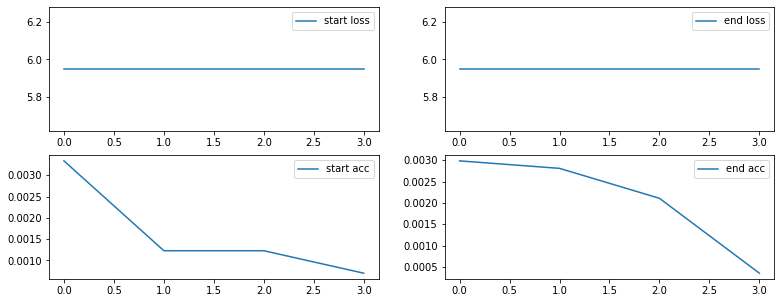

In [37]:
history_plot(history1)

---

**Pre-trained 모델 활용**

In [27]:
finetune = os.path.join(model_dir, 'bert_pretrain_32000.hdf5') # pre-trained

model2 = BERTModel(config) # 모델 생성

x = np.random.randint(0, len(vocab), (4, 10))
s = np.random.randint(0, 2, (4, 10))
model2(x, s)

model2.load_weights(finetune, by_name = True) # apply pre-trained 
model2.summary()

Model: "bert_korquad"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (BERT)                  multiple                  29202944  
_________________________________________________________________
dense_36 (Dense)             multiple                  1026      
Total params: 29,203,970
Trainable params: 29,203,970
Non-trainable params: 0
_________________________________________________________________


In [28]:
model2_1, history2_1 = train(model2, 1) # epoch 1

  0%|          | 0/1875 [00:00<?, ?it/s]

epoch 0 evaluate
loss 1.7247, 1.9793
acc 0.5502, 0.5151
Saved best model


In [29]:
result(dev, model2_1)

0
question : 임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
context :
 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
answer : 1989년 2월 15일
prediction : 1989년 2월 15일
------------------------------------------
1
question : 1989년 6월 30일 평양축전에 대표로 파견 된 인물은?
context :
 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 19

In [30]:
model2_2, history2_2 = train(model2, 1) # epoch 1+1=2

  0%|          | 0/1875 [00:00<?, ?it/s]

epoch 0 evaluate
loss 1.6424, 1.8651
acc 0.5785, 0.5406
Saved best model


In [31]:
result(dev, model2_2)

0
question : 임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
context :
 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
answer : 1989년 2월 15일
prediction : 1989년 2월 15일
------------------------------------------
1
question : 1989년 6월 30일 평양축전에 대표로 파견 된 인물은?
context :
 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 19

In [32]:
model2_3, history2_3 = train(model2, 1) # epoch 2+1=3

  0%|          | 0/1875 [00:00<?, ?it/s]

epoch 0 evaluate
loss 1.8463, 2.1241
acc 0.5634, 0.5137
Saved best model


In [33]:
result(dev, model2_3)

0
question : 임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
context :
 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
answer : 1989년 2월 15일
prediction : 1989년 2월 15일
------------------------------------------
1
question : 1989년 6월 30일 평양축전에 대표로 파견 된 인물은?
context :
 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 19

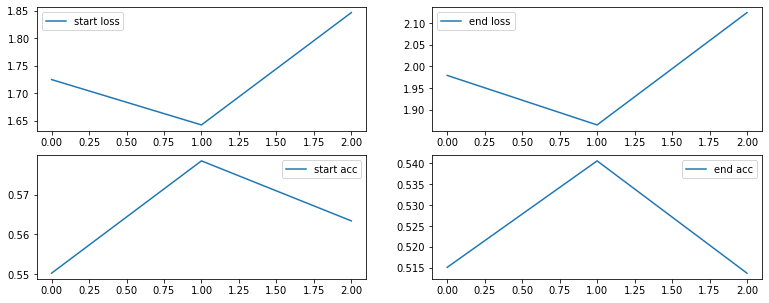

In [35]:
history2 = [[], [], [], []]

history2[0] = history2_1[0] + history2_2[0] + history2_3[0]
history2[1] = history2_1[1] + history2_2[1] + history2_3[1]
history2[2] = history2_1[2] + history2_2[2] + history2_3[2]
history2[3] = history2_1[3] + history2_2[3] + history2_3[3]

history_plot(history2)

---

In [36]:
from IPython.display import Image

**프로젝트 평가**

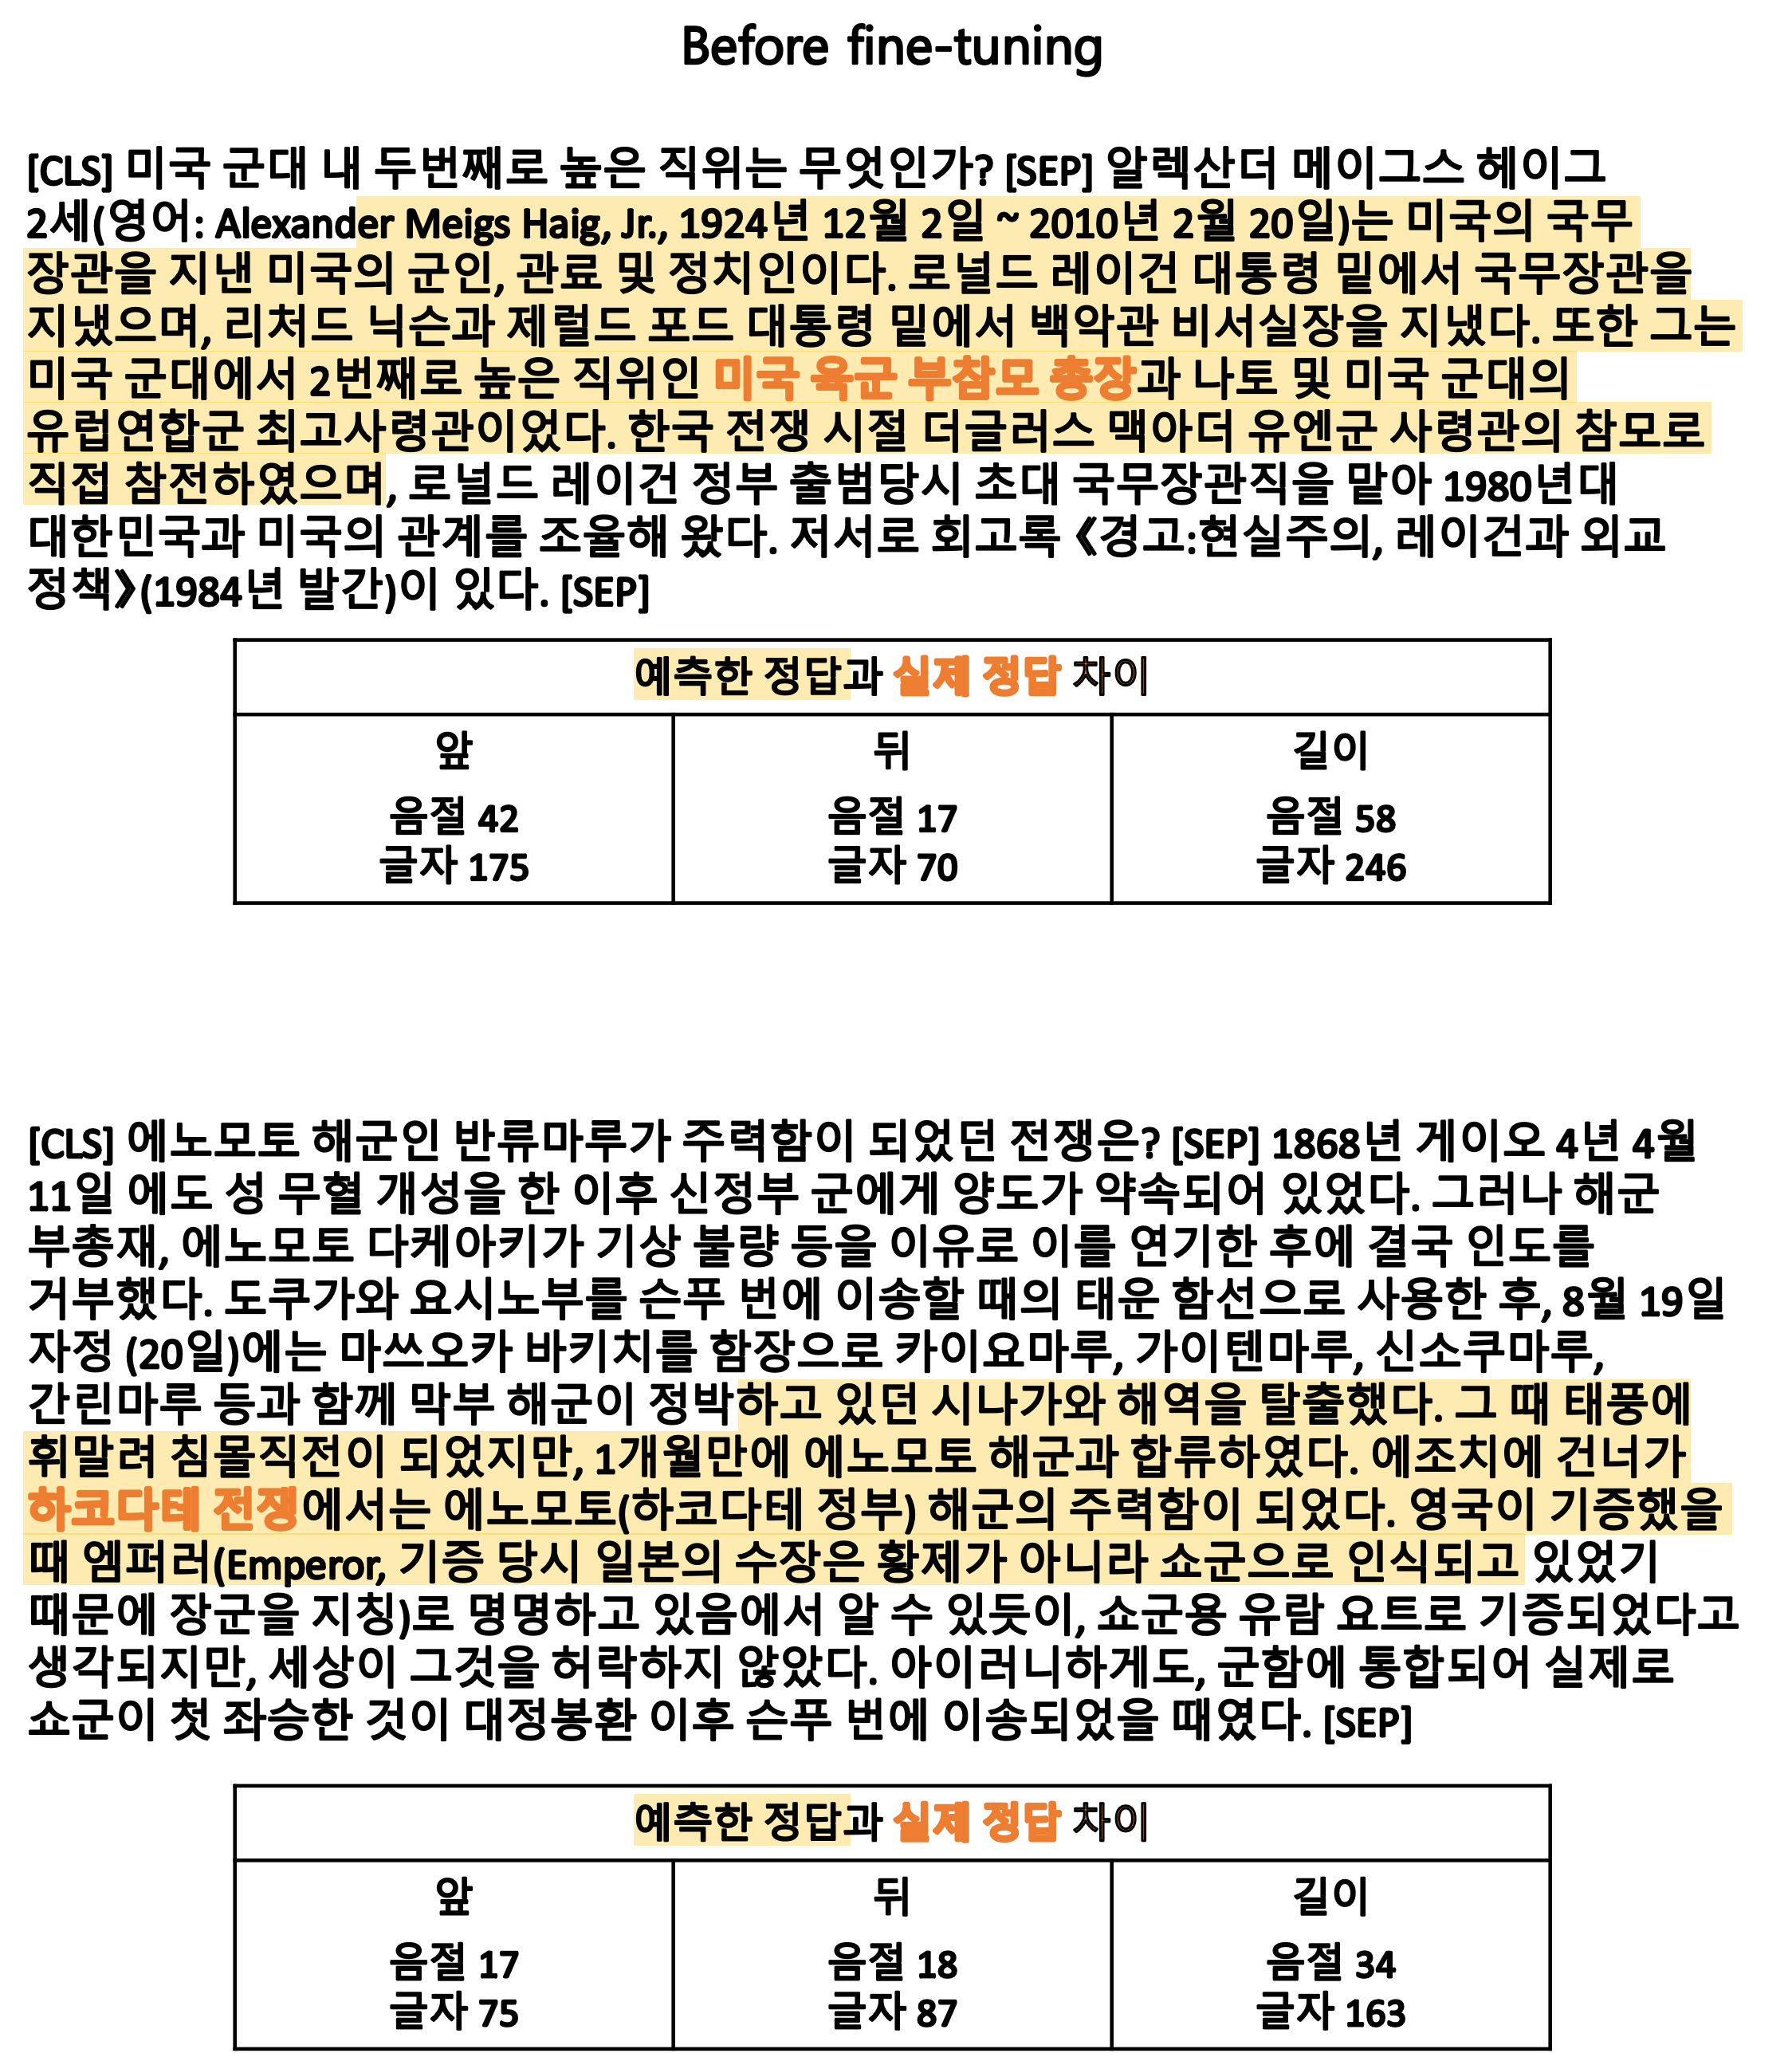

In [46]:
# 일반 모델
Image("before.png", width = 500)

* 정답을 포함하고 있기는 하지만 거의 맞추고 있지 않습니다.

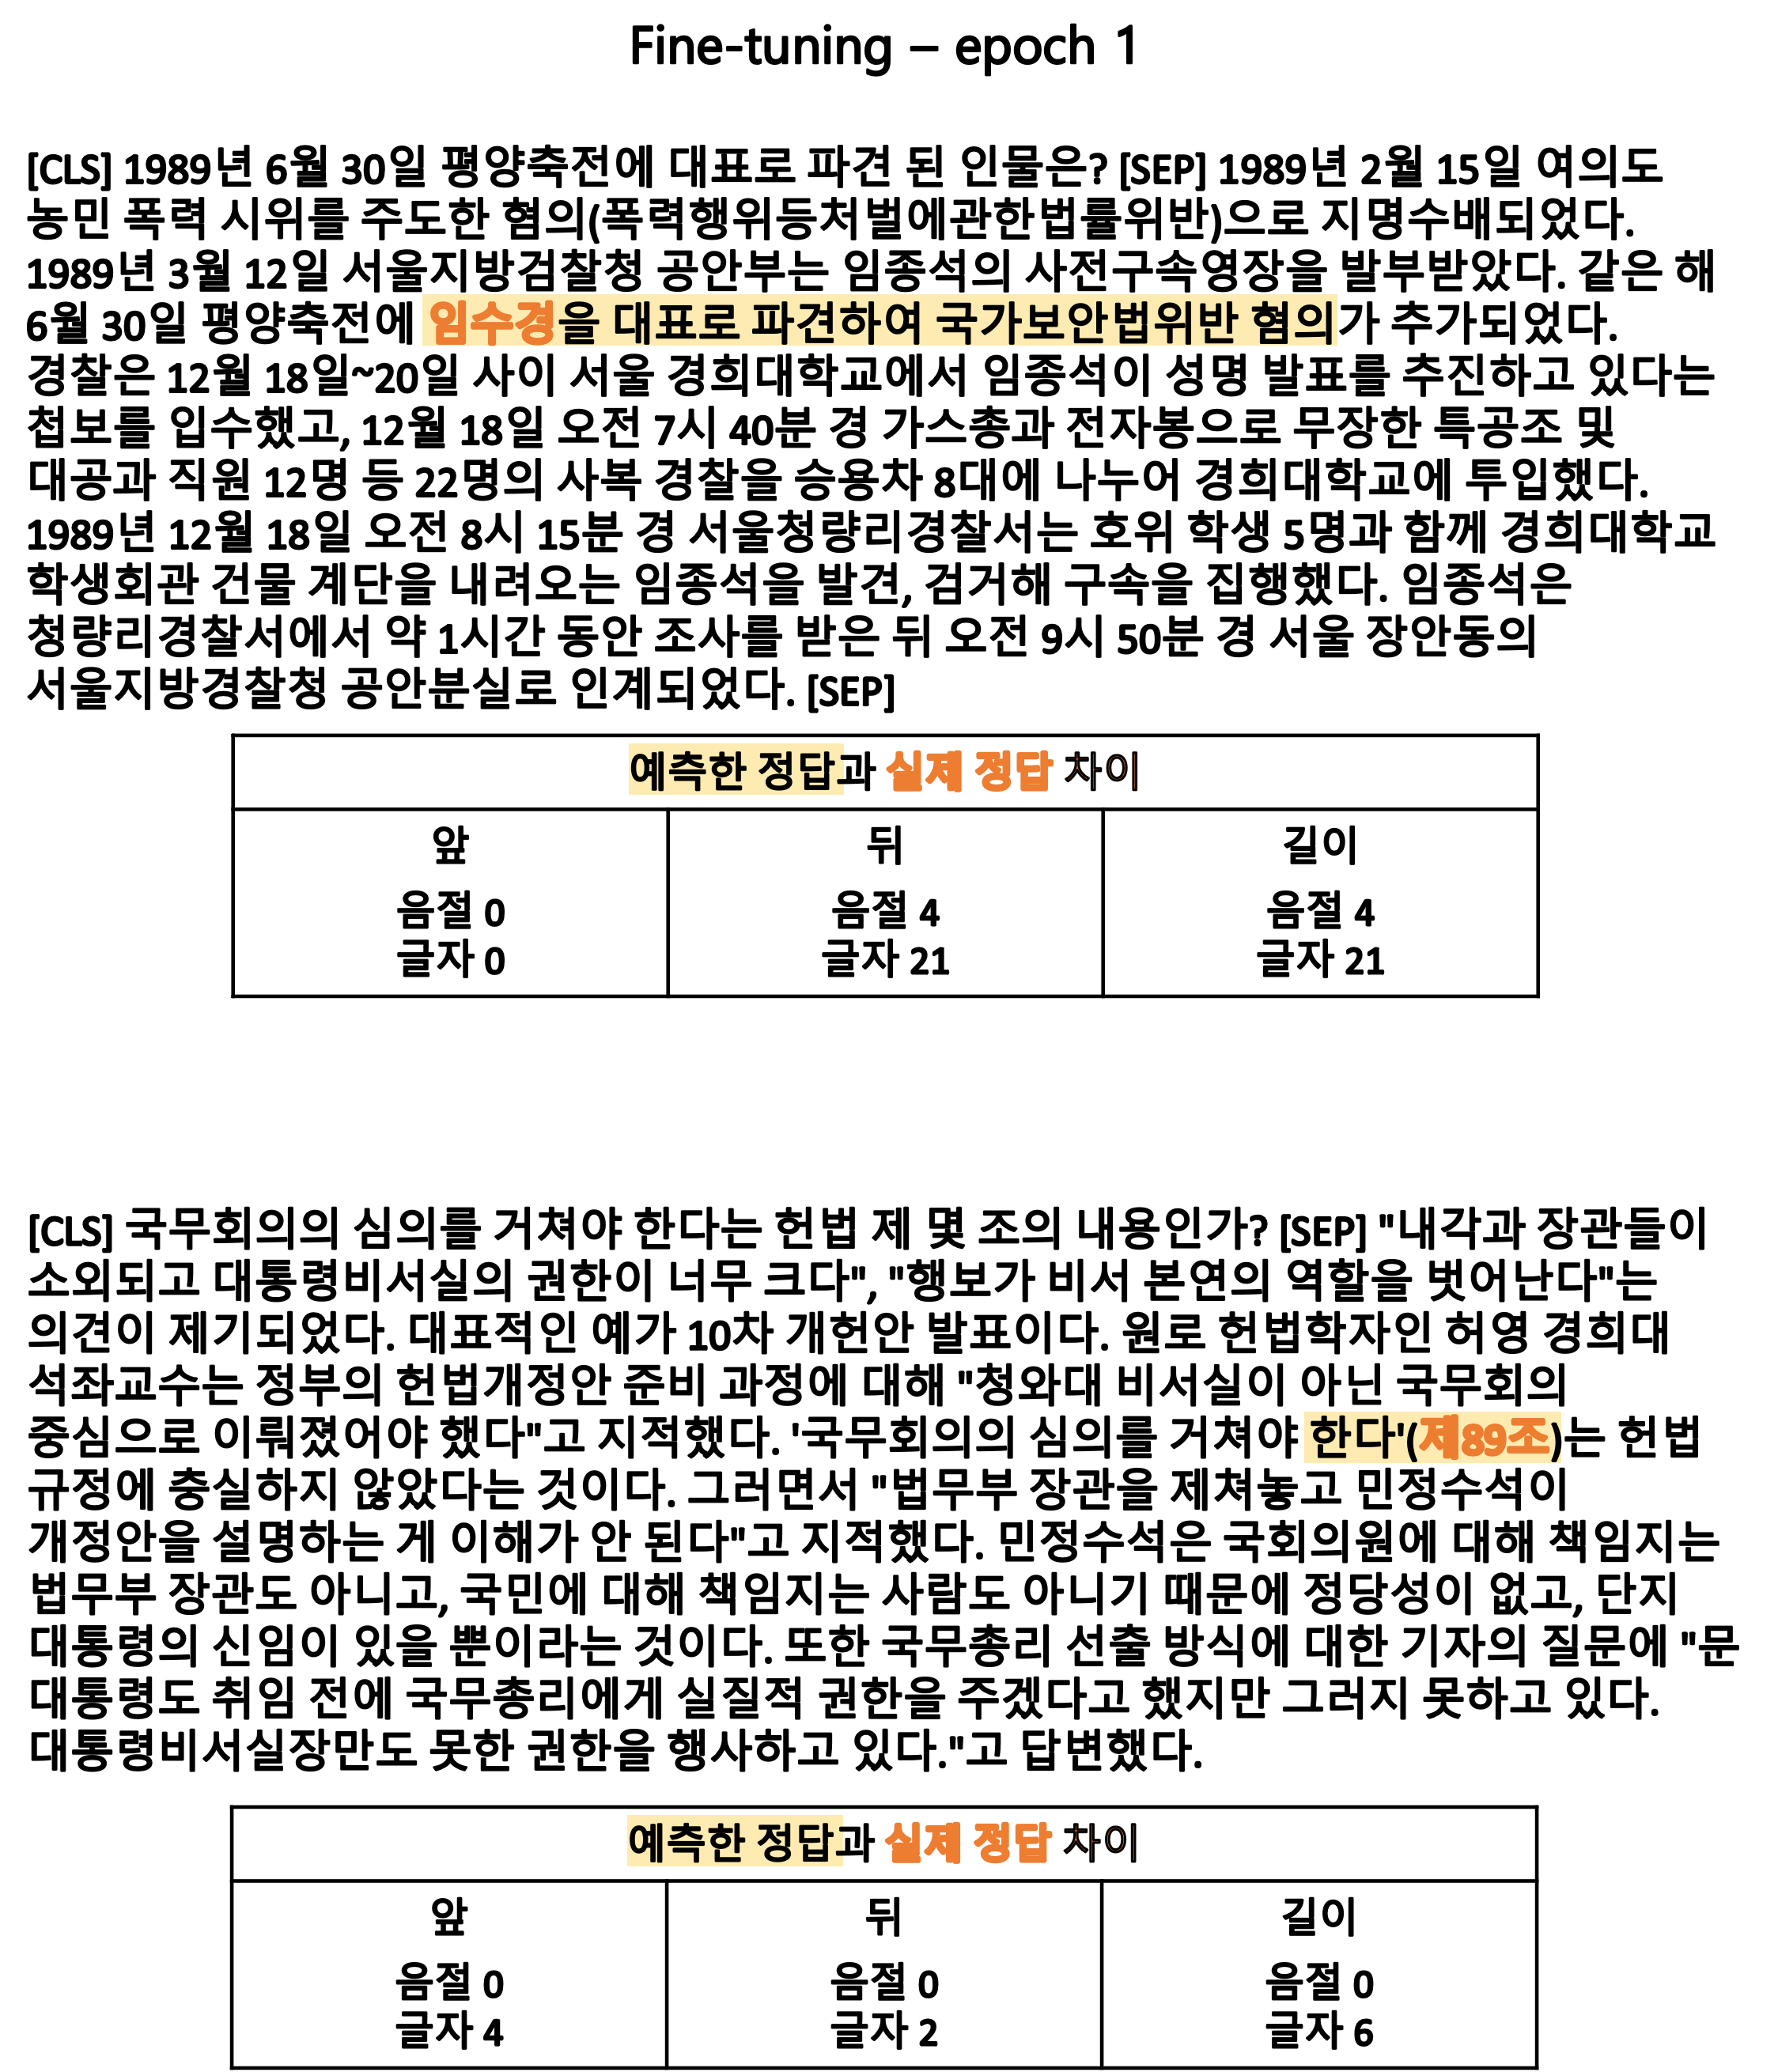

In [47]:
# pre-trained model epoch 1
Image("finetune1.png", width = 500)

* 거의 정답에 근접합니다.

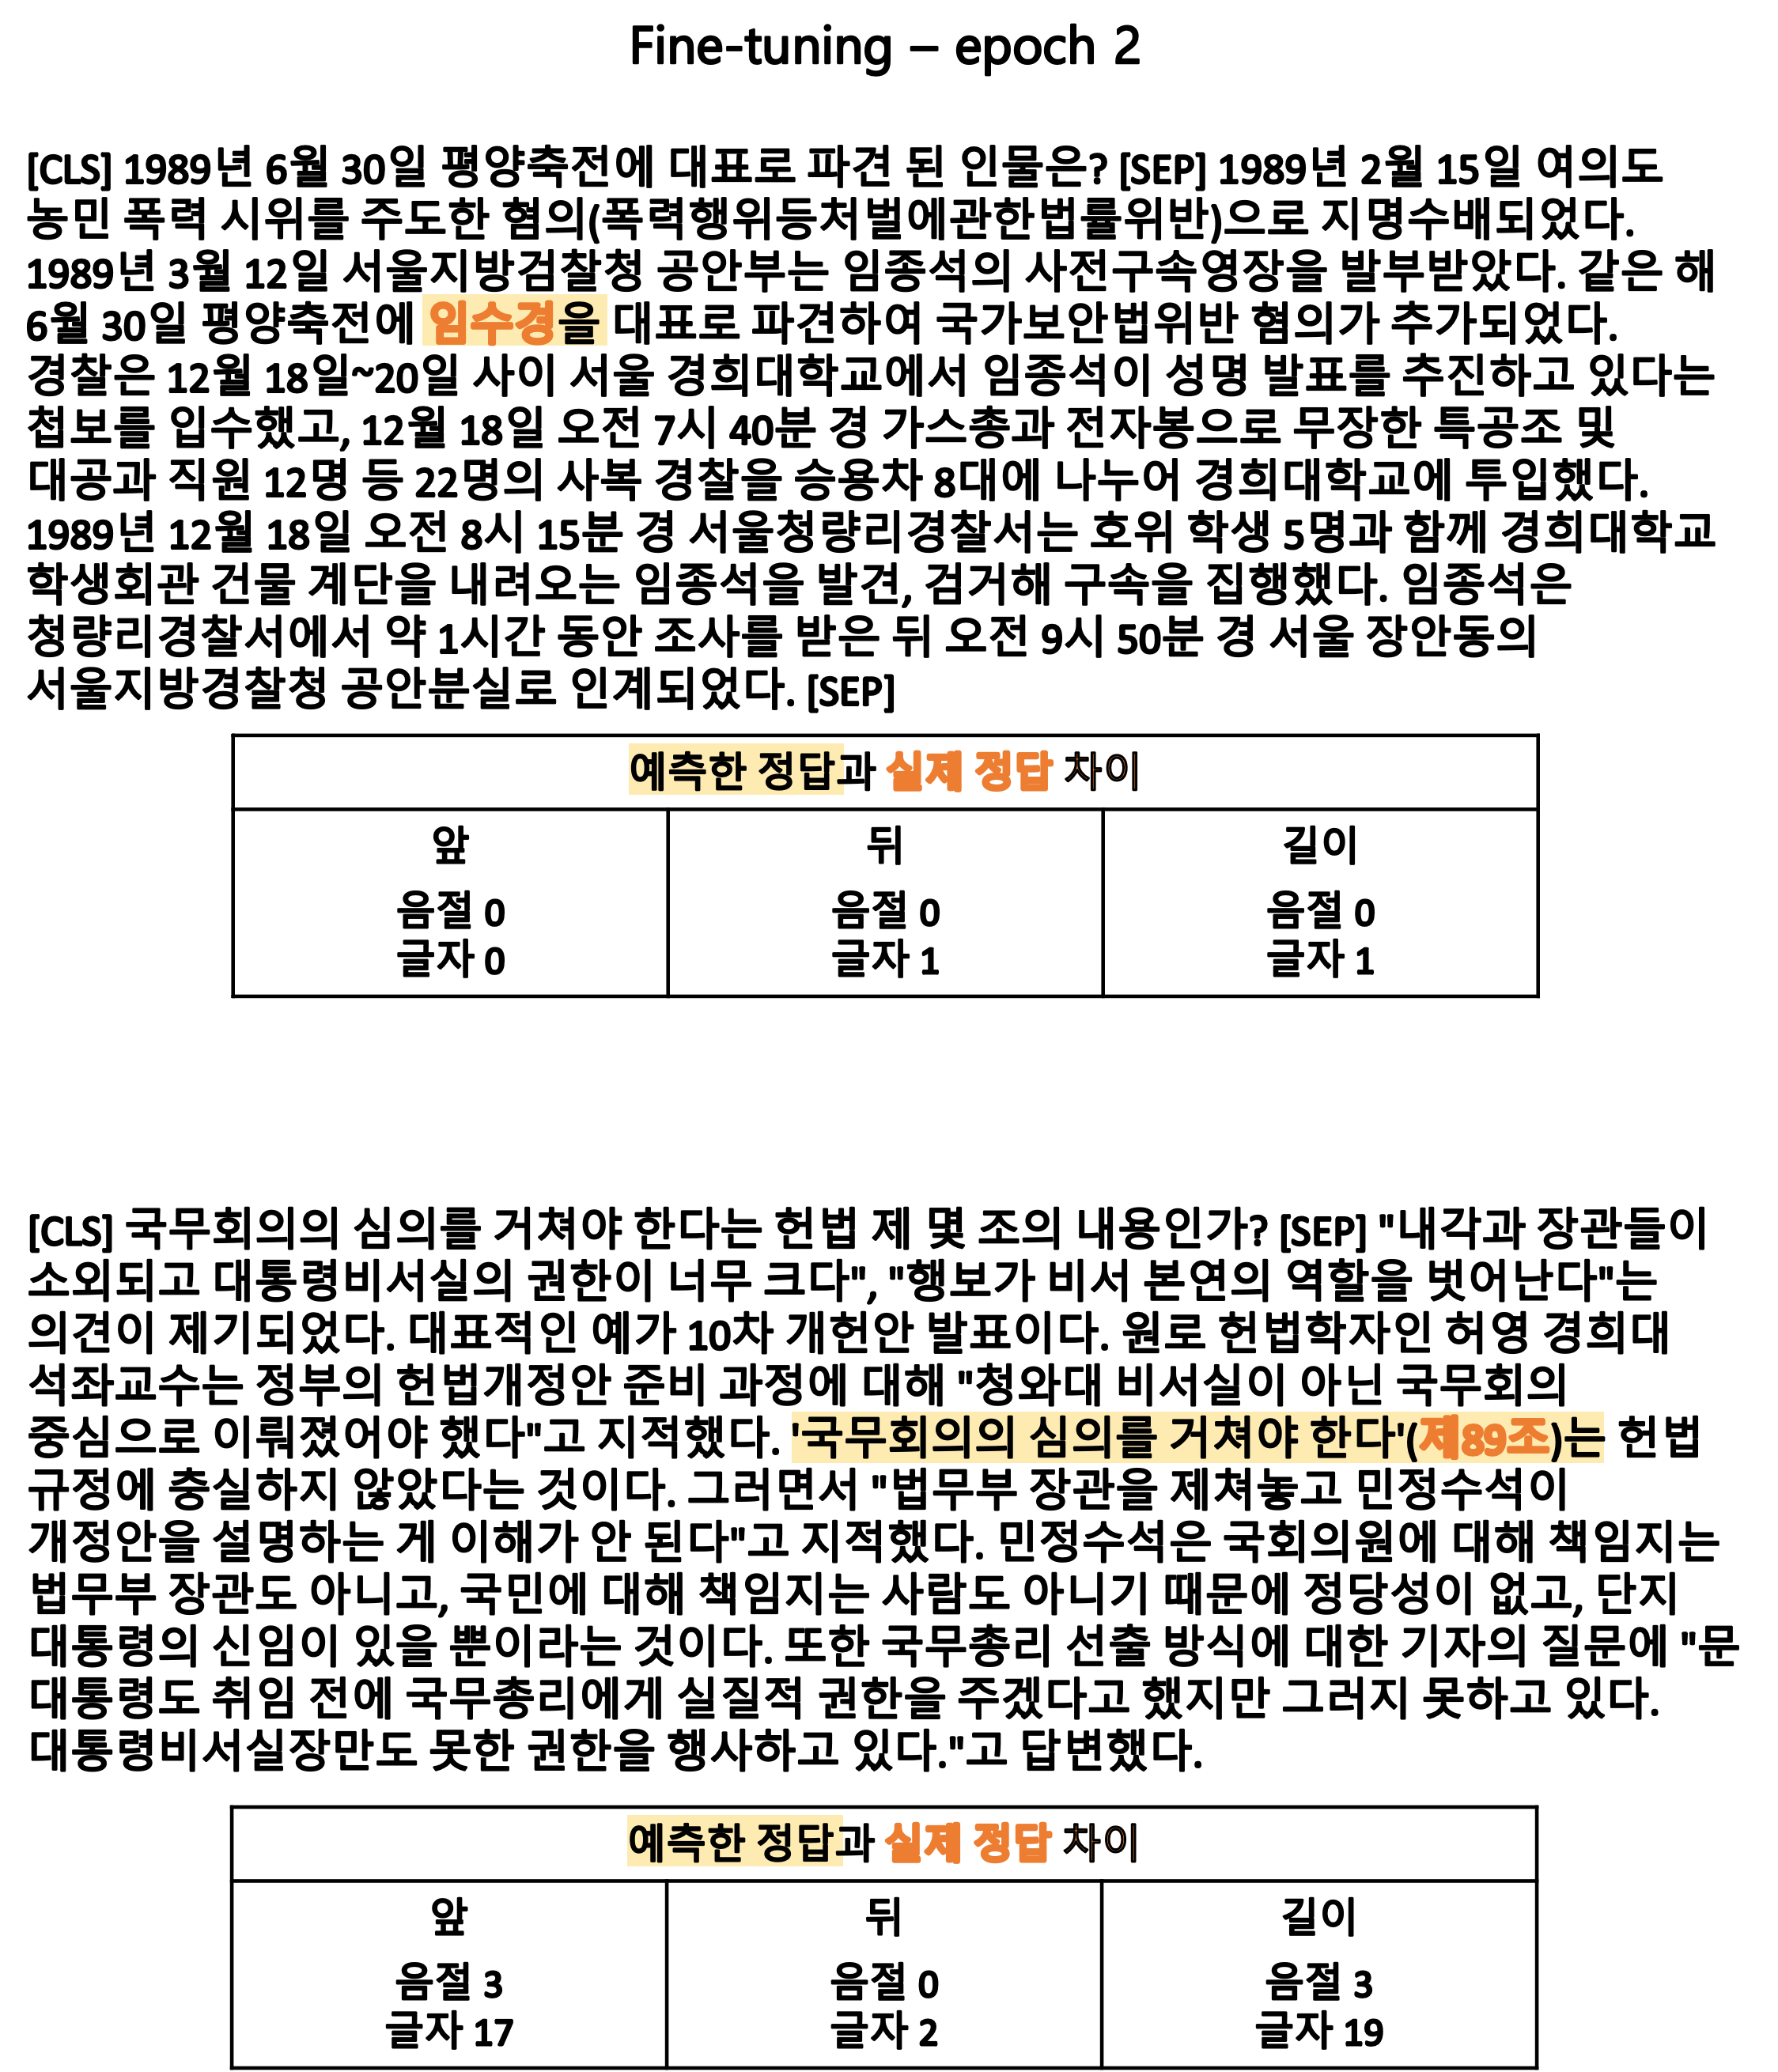

In [48]:
# pre-trained model epoch 2
Image("finetune2.png", width = 500)

* 위와 비슷하게 정답에 근접합니다.

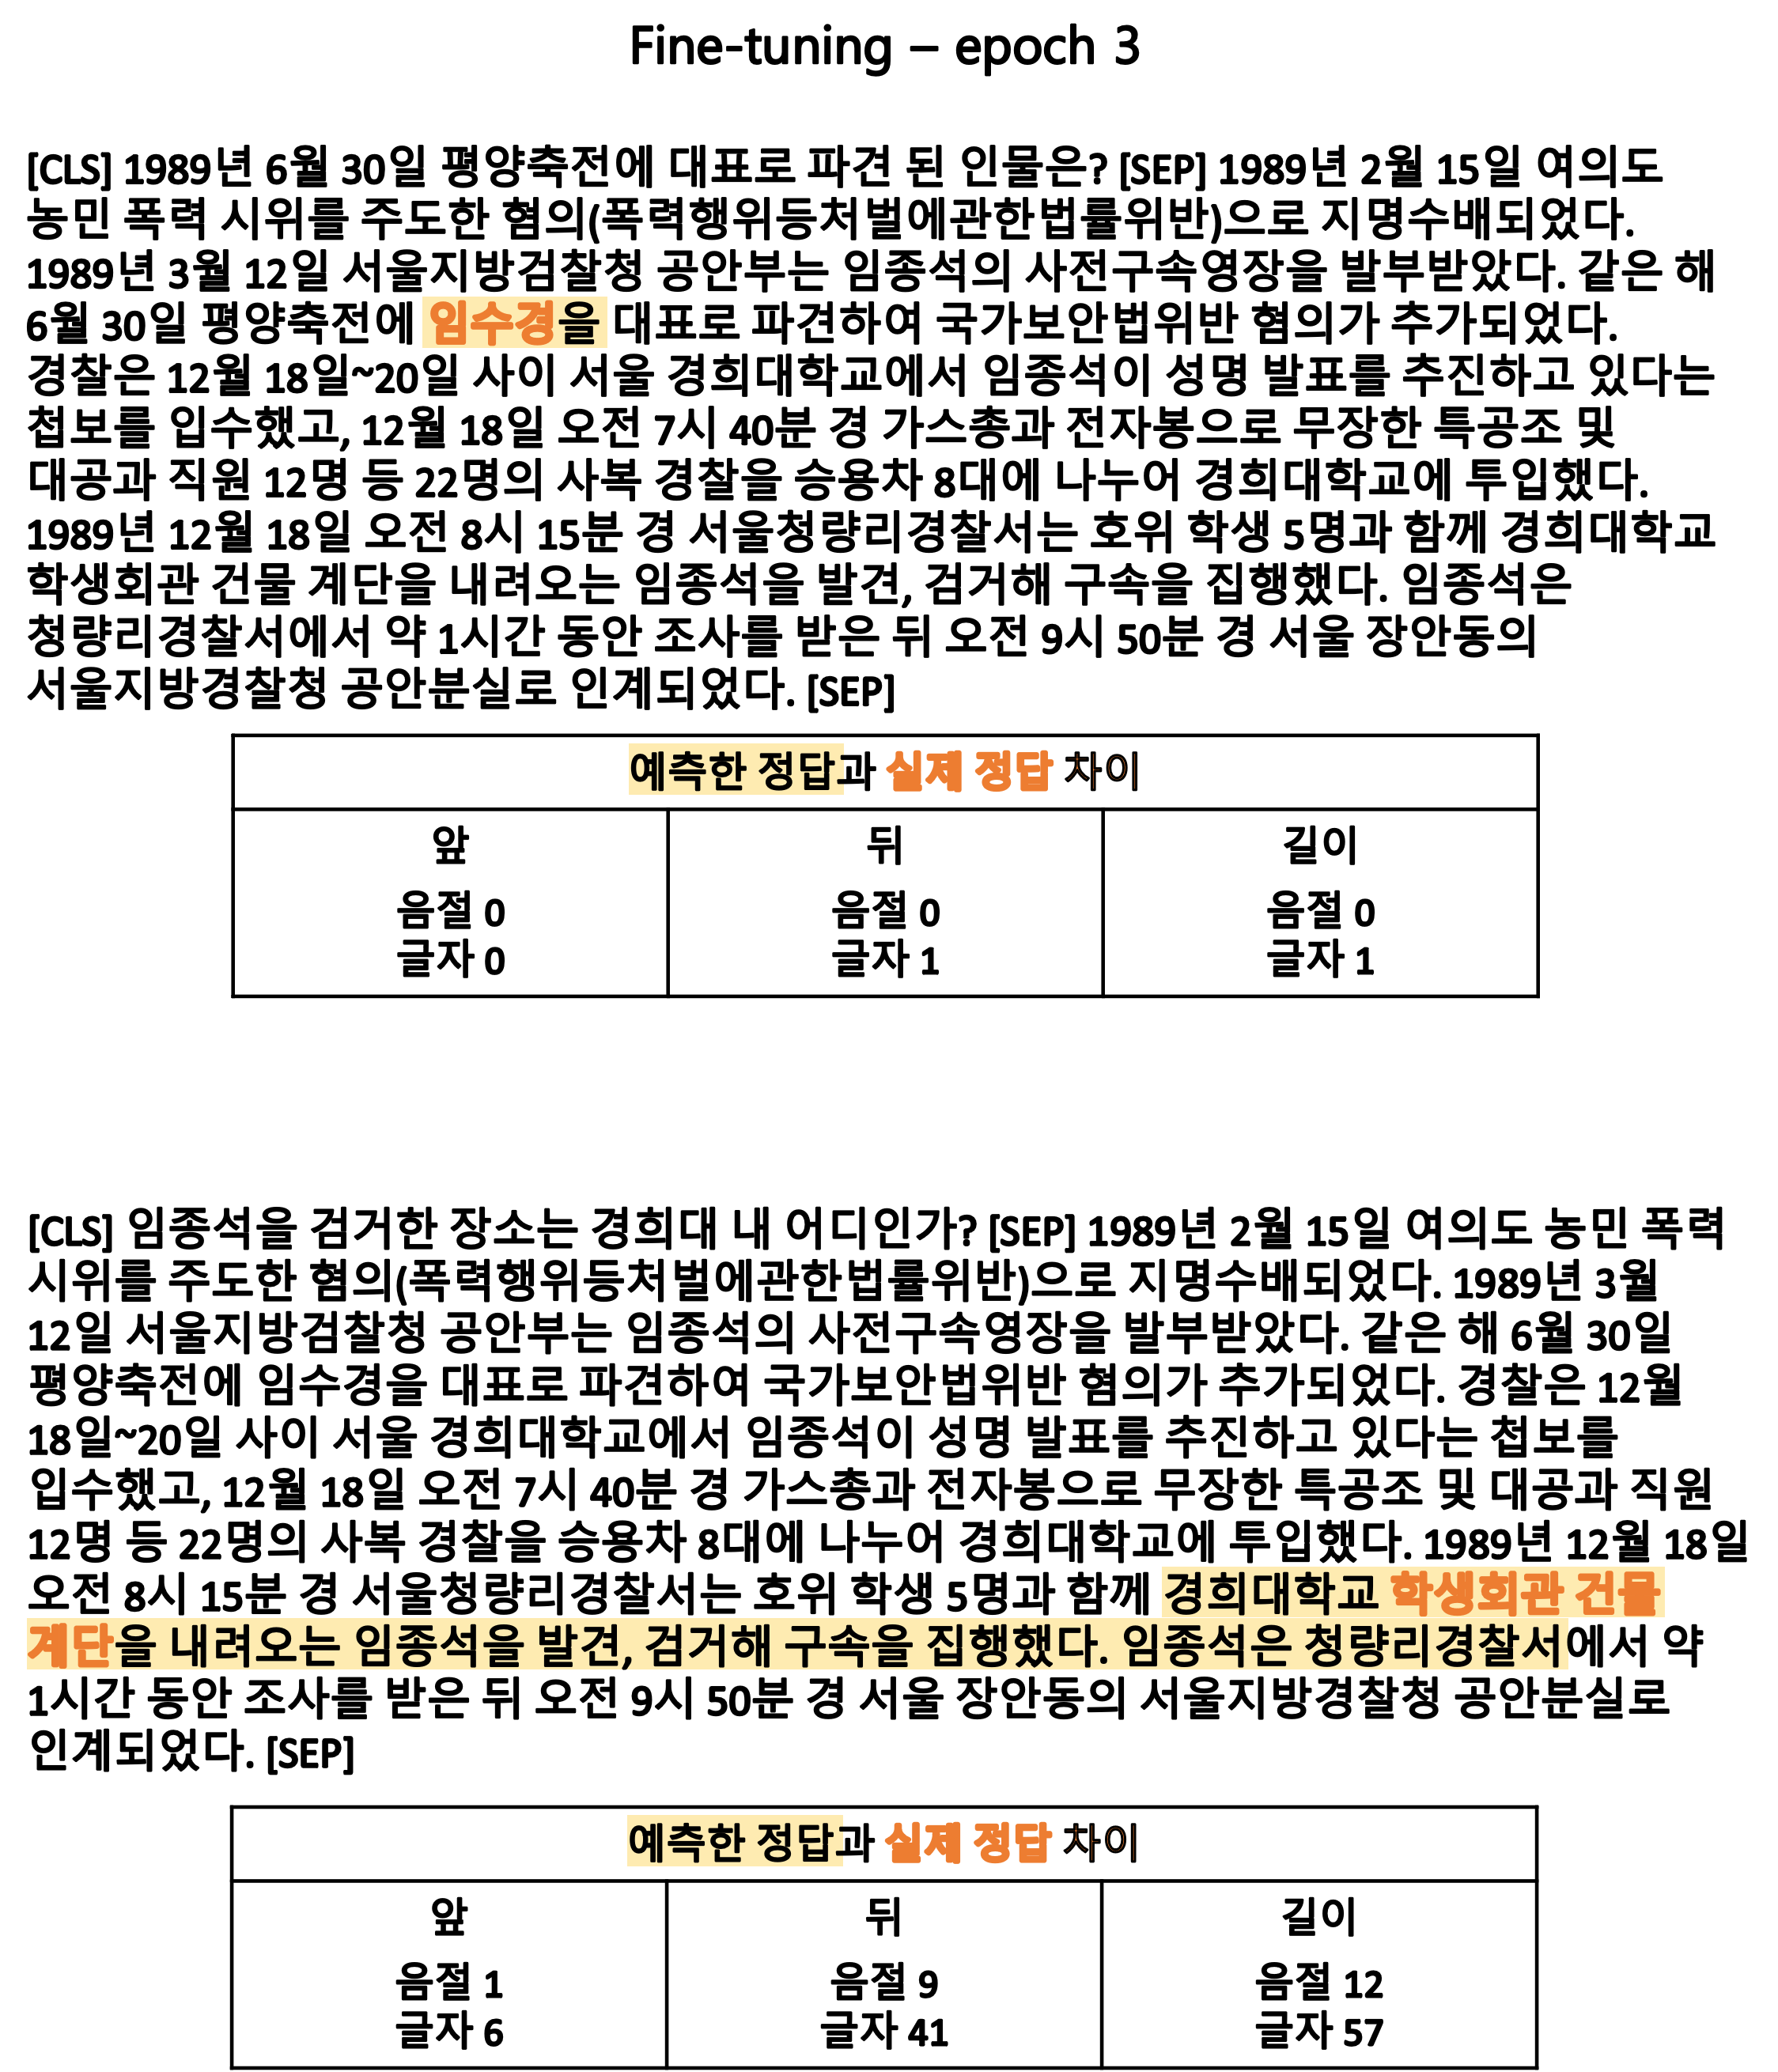

In [49]:
# pre-trained model epoch 3
Image("finetune3.png", width = 500)

* 위와 비슷하게 정답에 근접합니다.

---

**일반 모델 성능**

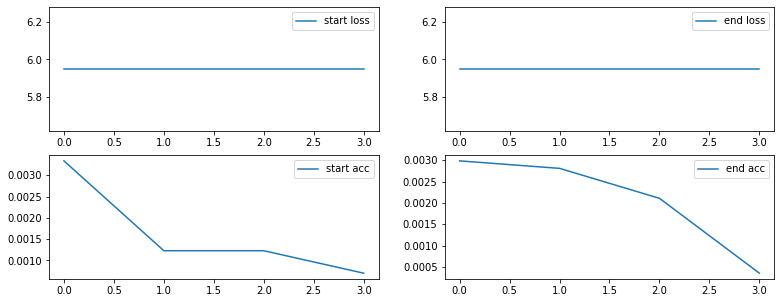

* 일반 모델의 epoch 0부터 3까지 4회입니다.
* 특이하게도 epoch 4회 동안 loss의 변함이 없습니다.
* acc는 최초부터 급격하게 감소합니다.

<br/>

**pre-trained model**

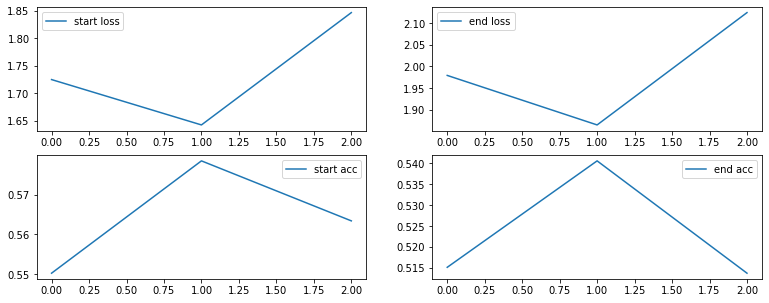

* pre-trained model의 epoch 0부터 2까지 3회입니다.
* pre-trained model의 loss가 감소했다가 증가합니다.
* pre-trained model의 acc가 증가했다가 감소합니다.

---

**회고**

* 훈련 시간이 길기 때문에 다양한 시도를 하기 어려웠고,
* GPU 메모리 부족으로 발생하는 ResourceExhaustedError: OOM 에러를 다수 겪었습니다. 😥